<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fgeneration/applications/generation/image_captioning/Basic%20Image%20to%20Latex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IM2LATEX Dataset

In [12]:
!mkdir data
!cd data

In [13]:
!wget -P data http://lstm.seas.harvard.edu/latex/data/im2latex_validate_filter.lst
!wget -P data http://lstm.seas.harvard.edu/latex/data/im2latex_train_filter.lst
!wget -P data http://lstm.seas.harvard.edu/latex/data/im2latex_test_filter.lst
!wget -P data http://lstm.seas.harvard.edu/latex/data/formula_images_processed.tar.gz
!wget -P data http://lstm.seas.harvard.edu/latex/data/im2latex_formulas.norm.lst
!tar -zxf data/formula_images_processed.tar.gz -C data/

--2020-07-25 16:38:25--  http://lstm.seas.harvard.edu/latex/data/im2latex_validate_filter.lst
Resolving lstm.seas.harvard.edu (lstm.seas.harvard.edu)... 52.32.77.68
Connecting to lstm.seas.harvard.edu (lstm.seas.harvard.edu)|52.32.77.68|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175153 (171K) [text/plain]
Saving to: ‘data/im2latex_validate_filter.lst’

im2latex_validate_f 100%[===================>] 171.05K   371KB/s    in 0.5s    

2020-07-25 16:38:26 (371 KB/s) - ‘data/im2latex_validate_filter.lst’ saved [175153/175153]

--2020-07-25 16:38:31--  http://lstm.seas.harvard.edu/latex/data/im2latex_train_filter.lst
Resolving lstm.seas.harvard.edu (lstm.seas.harvard.edu)... 52.32.77.68
Connecting to lstm.seas.harvard.edu (lstm.seas.harvard.edu)|52.32.77.68|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1575352 (1.5M) [text/plain]
Saving to: ‘data/im2latex_train_filter.lst’

im2latex_train_filt 100%[===================>]   1.50M  1.18MB

In [14]:
!ls data

formula_images_processed	 im2latex_test_filter.lst
formula_images_processed.tar.gz  im2latex_train_filter.lst
im2latex_formulas.norm.lst	 im2latex_validate_filter.lst


In [15]:
data_path = "data"

### Imports

In [16]:
import os
import time
import math
import pickle
import numpy as np
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data Exploration

In [18]:
# formuals file
formulas_file = os.path.join(data_path, "im2latex_formulas.norm.lst")
with open(formulas_file, 'r') as f:
    formulas = [formula.split('\n')[0] for formula in f.readlines()]

In [19]:
train_formulas_file = os.path.join(data_path, "im2latex_train_filter.lst")
with open(train_formulas_file, 'r') as f:
    # img_name, formula_id= line.strip('\n').split()
    train_formulas = [line.strip('\n').split() for line in f.readlines()]

In [20]:
len(train_formulas)

75275

In [21]:
train_formulas[0]

['66667cee5b.png', '2']

In [22]:
temp = os.listdir(os.path.join(data_path, "formula_images_processed"))
len(temp)

103536

(<matplotlib.image.AxesImage at 0x7f70ac7a5978>,
 '\\widetilde \\gamma _ { \\mathrm { h o p f } } \\simeq \\sum _ { n > 0 } \\widetilde { G } _ { n } { \\frac { ( - a ) ^ { n } } { 2 ^ { 2 n - 1 } } }')

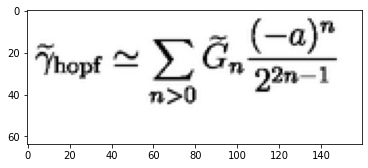

In [23]:
img_path = os.path.join(data_path, "formula_images_processed", train_formulas[0][0])
img = Image.open(img_path)
plt.imshow(np.asarray(img)), formulas[int(train_formulas[0][1])]

(<matplotlib.image.AxesImage at 0x7f70ac24c240>,
 'e x p \\left( - \\frac { \\partial } { \\partial \\alpha _ { j } } \\theta ^ { j k } \\frac { \\partial } { \\partial \\alpha _ { k } } \\right)')

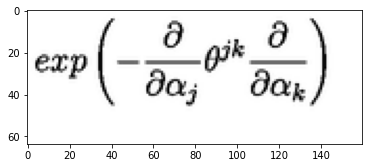

In [25]:
img_path = os.path.join(data_path, "formula_images_processed", train_formulas[10][0])
img = Image.open(img_path)
plt.imshow(np.asarray(img)), formulas[int(train_formulas[10][1])]

### Pre-processing

Since the dataset is huge, I will be taking only a subset of it. You can take the complete dataset based on the available RAM

In [26]:
def resize_image(image, size):
    return image.resize(size, Image.ANTIALIAS)

In [27]:
def preprocess(data_dir, split, transform):
    assert split in ["train", "validate", "test"]
    print(f"Processing {split} data...")

    if split == "train":
        max_samples = 70000
    elif split == "validate":
        max_samples = 1000
    elif split == "test":
        max_samples = 1000
    
    # images directory
    images_dir = os.path.join(data_dir, "formula_images_processed")
    
    # formuals file
    formulas_file = os.path.join(data_dir, "im2latex_formulas.norm.lst")
    with open(formulas_file, 'r') as f:
        formulas = [formula.split('\n')[0] for formula in f.readlines()]
    
    split_file = os.path.join(data_dir, f"im2latex_{split}_filter.lst")
    pairs = []
    count = 0
    size = [128, 32]
    with open(split_file, 'r') as f:
        for line in f:
            img_name, formula_id = line.strip('\n').split()
            img_path = os.path.join(images_dir, img_name)
            img = Image.open(img_path)
            img = resize_image(img, size)
            img_tensor = transform(img)
            formula = formulas[int(formula_id)]
            pair = (img_tensor, formula)
            pairs.append(pair)
            count += 1
            if count == max_samples:
                break
    
    pairs.sort(key=img_size)
    # save the formulas used in training for building vocabulary
    if split == "train":
        sampled_formulas = [form for (img, form) in pairs]
        form_file = os.path.join(data_dir, f"{split}_sampled_formula.pkl")
        print("saving sampled formulas...")
        with open(form_file, 'wb') as f:
            pickle.dump(sampled_formulas, f)

    out_file = os.path.join(data_dir, f"{split}.pkl")
    torch.save(pairs, out_file)
    print(f"Completed processing {split} data")

In [28]:
def img_size(pair):
    img, formula = pair
    return tuple(img.size())

In [29]:
%%time
transform = transforms.ToTensor()

preprocess(data_path, "train", transform)
preprocess(data_path, "validate", transform)
preprocess(data_path, "test", transform)

Processing train data...
saving sampled formulas...
Completed processing train data
Processing validate data...
Completed processing validate data
Processing test data...
Completed processing test data
CPU times: user 1min 10s, sys: 7.24 s, total: 1min 17s
Wall time: 2min 15s


### Vocabulary

In [30]:
PAD_TOKEN = 0
START_TOKEN = 1
END_TOKEN = 2
UNK_TOKEN = 3

In [31]:
class Vocab(object):
    def __init__(self):
        self.sign2id = {
            "<s>": START_TOKEN,
            "</s>": END_TOKEN,
            "<pad>": PAD_TOKEN,
            "<unk>": UNK_TOKEN
        }

        self.id2sign = dict((id, sign) for sign, id in self.sign2id.items())
        self.length = 4
    
    def add_sign(self, sign):
        if sign not in self.sign2id:
            self.sign2id[sign] = self.length
            self.id2sign[self.length] = sign
            self.length += 1
    
    def __len__(self):
        return self.length
    
    def __call__(self, sign):
        if not sign in self.sign2id:
            return self.sign2id['<unk>']
        return self.sign2id[sign]

In [32]:
def build_vocab(data_dir, min_count=10):
    vocab = Vocab()
    counter = Counter()

    with open(os.path.join(data_dir, 'train_sampled_formula.pkl'), 'rb') as f:
        formulas = pickle.load(f)

    for formula in formulas:
        counter.update(formula.split())

    for word, count in counter.most_common():
        if count >= min_count:
            vocab.add_sign(word)
    
    vocab_file = os.path.join(data_dir, 'vocab.pkl')
    print("saving vocabulary...")
    with open(vocab_file, 'wb') as f:
        pickle.dump(vocab, f)

In [33]:
def load_vocab(data_dir):
    with open(os.path.join(data_dir, 'vocab.pkl'), 'rb') as f:
        vocab = pickle.load(f)
    return vocab

In [34]:
%%time
build_vocab(data_path)

saving vocabulary...
CPU times: user 605 ms, sys: 3.45 ms, total: 609 ms
Wall time: 883 ms


In [35]:
vocab = load_vocab(data_path)

### Dataset

In [36]:
class Im2LatexDataset(data.Dataset):
    def __init__(self, data_dir, split):
        assert split in {'train', 'validate', 'test'}
        self.data_dir = data_dir
        self.split = split
        self.data = self._load_data()
    
    def _load_data(self):
        pairs = torch.load(os.path.join(self.data_dir, f"{self.split}.pkl"))
        for i, (img, formula) in enumerate(pairs):
            pair = (img, " ".join(formula.split()))
            pairs[i] = pair
        return pairs

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        img, formula = self.data[item]
        formula = formula.split()
        tokens = []
        tokens.append(vocab('<s>'))
        tokens.extend([vocab(sign) for sign in formula])
        tokens.append(vocab('</s>'))

        formula = torch.Tensor(tokens)
        return img, formula

In [37]:
%%time
train_dataset = Im2LatexDataset(data_path, 'train')
valid_dataset = Im2LatexDataset(data_path, 'validate')
test_dataset = Im2LatexDataset(data_path, 'test')

CPU times: user 2.32 s, sys: 1.89 s, total: 4.21 s
Wall time: 29.1 s


### DataLoader

In [38]:
torch.cuda.empty_cache()

In [39]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, formulas = zip(*data)

    # merge images
    images = torch.stack(images, 0)

    lengths = [len(form) for form in formulas]
    targets = torch.zeros(len(formulas), max(lengths)).long()
    for i, form in enumerate(formulas):
        end = lengths[i]
        targets[i, :end] = form[:end]
    
    return images, targets, lengths

In [40]:
batch_size = 32

In [41]:
train_data_loader = data.DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=collate_fn)
valid_data_loader = data.DataLoader(valid_dataset, batch_size, shuffle=False, collate_fn=collate_fn)
test_data_loader = data.DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=collate_fn)

In [42]:
# sample check
sample = next(iter(train_data_loader))
sample[0].shape, sample[1].shape, len(sample[2])

(torch.Size([32, 3, 32, 128]), torch.Size([32, 138]), 32)

### Encoder

In [43]:
class Encoder(nn.Module):
    def __init__(self, enc_out_dim=300):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 1),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 1),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d((2, 1), (2, 1), 0),

            nn.Conv2d(256, enc_out_dim, 3, 1, 0),
            nn.ReLU()
        )
    
    def forward(self, imgs):
        features = self.cnn(imgs)
        # features => [batch, 300, H, W]

        features = features.permute(0, 2, 3, 1)
        batch, H, W, _ = features.shape
        encoded_imgs = features.contiguous().view(batch, H*W, -1)
        return encoded_imgs

### Decoder

In [122]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, decoder_dim, num_layers, encoder_dim=300, dropout=0.3):
        super().__init__()

        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD_TOKEN)

        self.lstm = nn.LSTM(
            emb_dim,
            decoder_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)

        self.out = nn.Linear(decoder_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, features, formulas, lengths):
        mean_enc = features.mean(dim=1)
        # mean_enc => [batch_size, 300]
        embeddings = self.embedding(formulas)
        # embeddings => [batch_size, max_len, 300]
        embeddings = torch.cat((mean_enc.unsqueeze(1), embeddings), dim=1)
        # embeddings => [batch_size, max_len + 1, 300]

        hidden = self.init_h(mean_enc).unsqueeze(0).repeat(self.num_layers, 1, 1)
        cell = self.init_c(mean_enc).unsqueeze(0).repeat(self.num_layers, 1, 1)

        packed = nn.utils.rnn.pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.lstm(packed, (hidden, cell))
        outputs = self.out(hiddens[0])
        return outputs
    
    def sample(self, features, max_length=100):
        sampled_ids = []
        mean_enc = torch.mean(features, dim=1)
        img_features = torch.mean(features, dim=1).unsqueeze(1)
        start_token = torch.tensor([[vocab('<s>')]]).to(device)
        emb = self.embedding(start_token)
        inputs = torch.cat((img_features, emb), dim=1)

        hidden = self.init_h(mean_enc).unsqueeze(0).repeat(self.num_layers, 1, 1)
        cell = self.init_c(mean_enc).unsqueeze(0).repeat(self.num_layers, 1, 1)
        states = (hidden, cell)
        
        # inputs => [batch_size, 2, 300]
        for i in range(max_length):
            hidden, states = self.lstm(inputs, states)
            outputs = self.out(hidden[:, -1, :])
            _, predicted = outputs.max(1)
            sampled_ids.append(predicted)
            inputs = self.embedding(predicted)
            inputs = inputs.unsqueeze(1)
            inputs = torch.cat((img_features, inputs), dim=1)
        sampled_ids = torch.stack(sampled_ids, 1)
        return sampled_ids

### Model

In [60]:
enc_out_dim = 300
embed_size = 300
dec_hid_size = 512
num_layers = 2
dropout = 0.3

In [61]:
encoder = Encoder(enc_out_dim).to(device)
decoder = Decoder(
    len(vocab),
    embed_size,
    dec_hid_size,
    num_layers,
    enc_out_dim,
    dropout).to(device)

### Optimizer & Loss

In [62]:
params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = optim.Adam(params, lr=1e-3)
criterion = nn.CrossEntropyLoss()

### Training Method

In [63]:
def train(encoder, decoder, data_loader):
    encoder.train()
    decoder.train()
    epoch_loss = 0
    total_step = len(data_loader)

    for i, (images, formulas, lengths) in enumerate(data_loader):
        images = images.to(device)
        formulas = formulas.to(device)

        targets = nn.utils.rnn.pack_padded_sequence(formulas, lengths, batch_first=True)[0]

        features = encoder(images)
        outputs = decoder(features, formulas, lengths)
        loss = criterion(outputs, targets)

        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Print log info
        if i % 200 == 0:
            print(f'Step [{i}/{total_step}], Loss: {loss.item():.4f}, Perplexity: {np.exp(loss.item()):5.4f}')
    return epoch_loss / total_step    

### Evaluation Method

In [64]:
def evaluate(encoder, decoder, data_loader):
    encoder.eval()
    decoder.eval()
    epoch_loss = 0
    total_step = len(data_loader)

    with torch.no_grad():
        for i, (images, formulas, lengths) in enumerate(data_loader):
            images = images.to(device)
            formulas = formulas.to(device)

            targets = nn.utils.rnn.pack_padded_sequence(formulas, lengths, batch_first=True)[0]

            features = encoder(images)
            outputs = decoder(features, formulas, lengths)
            loss = criterion(outputs, targets)

            epoch_loss += loss.item()

            # Print log info
            if i % 50 == 0:
                print(f'Val Step [{i}/{total_step}], Loss: {loss.item():.4f}, Perplexity: {np.exp(loss.item()):5.4f}')
            
    return epoch_loss / total_step

### Training

In [65]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = elapsed_time - (elapsed_mins*60)
    return elapsed_mins, elapsed_secs

In [66]:
num_epochs = 10

In [67]:
best_val_loss = float('inf')
for epoch in range(num_epochs):

    start_time = time.time()
    train_loss = train(encoder, decoder, train_data_loader)
    val_loss = evaluate(encoder, decoder, valid_data_loader)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if val_loss <  best_val_loss:
        best_val_loss = val_loss
        torch.save(decoder.state_dict(), 'decoder.ckpt')
        torch.save(encoder.state_dict(), 'encoder.ckpt')

    print(f"Epoch: {epoch+1} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.4f}, Train PPL: {np.exp(train_loss):5.4f}")
    print(f"\tVal Loss: {val_loss:.4f}, Val PPL: {np.exp(val_loss):5.4f}")


Step [0/2188], Loss: 5.9597, Perplexity: 387.4786
Step [200/2188], Loss: 2.4485, Perplexity: 11.5715
Step [400/2188], Loss: 2.3190, Perplexity: 10.1652
Step [600/2188], Loss: 2.3822, Perplexity: 10.8287
Step [800/2188], Loss: 2.3027, Perplexity: 10.0012
Step [1000/2188], Loss: 2.1097, Perplexity: 8.2455
Step [1200/2188], Loss: 1.9567, Perplexity: 7.0759
Step [1400/2188], Loss: 1.9379, Perplexity: 6.9442
Step [1600/2188], Loss: 1.9064, Perplexity: 6.7285
Step [1800/2188], Loss: 1.8547, Perplexity: 6.3899
Step [2000/2188], Loss: 1.6768, Perplexity: 5.3485
Val Step [0/32], Loss: 1.7122, Perplexity: 5.5413
Epoch: 1 | Time: 5m 309.49311232566833s
	Train Loss: 2.1275, Train PPL: 8.3935
	Val Loss: 1.8199, Val PPL: 6.1714
Step [0/2188], Loss: 1.7796, Perplexity: 5.9273
Step [200/2188], Loss: 1.8831, Perplexity: 6.5739
Step [400/2188], Loss: 1.8705, Perplexity: 6.4915
Step [600/2188], Loss: 1.8509, Perplexity: 6.3657
Step [800/2188], Loss: 1.7905, Perplexity: 5.9923
Step [1000/2188], Loss: 1.70

### Testing

In [68]:
vocab_path = "data/vocab.pkl"
# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [123]:
# Build models
encoder = Encoder(enc_out_dim).eval()
decoder = Decoder(
    len(vocab),
    embed_size,
    dec_hid_size,
    num_layers,
    enc_out_dim,
    dropout).eval()
encoder = encoder.to(device)
decoder = decoder.to(device)

In [124]:
encoder_path = "encoder.ckpt"
decoder_path = "decoder.ckpt"

# Load the trained model parameters
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

<All keys matched successfully>

In [71]:
test_loss = evaluate(encoder, decoder, test_data_loader)
print(f"Test Loss: {test_loss:.4f} | Test PPL: {np.exp(test_loss):5.4f}")

Val Step [0/32], Loss: 1.3628, Perplexity: 3.9072
Test Loss: 1.3658 | Test PPL: 3.9188


### Inference

In [72]:
def load_image(image_path, transform):
    image = Image.open(image_path)
    img = resize_image(image, [128, 32])
    img_tensor = transform(img).unsqueeze(0)

    return img_tensor

In [125]:
def inference(image_path):
    # Prepare an image
    transform = transforms.ToTensor()
    image = load_image(image_path, transform)
    image_tensor = image.to(device)
    
    # Generate an caption from the image
    feature = encoder(image_tensor)

    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)

    # Convert word_ids to words
    sampled_formula = []
    for sign_id in sampled_ids:
        sign = vocab.id2sign[sign_id]
        if sign == '</s>':
            break
        sampled_formula.append(sign)
    formula = ' '.join(sampled_formula[1:])

    return formula

Actual: e x p \left( - \frac { \partial } { \partial \alpha _ { j } } \theta ^ { j k } \frac { \partial } { \partial \alpha _ { k } } \right)
Predicted: { e c _ { \kern - 2 e x \Big ) }


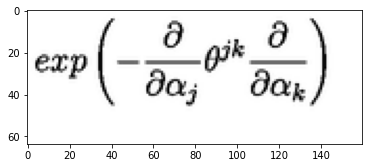

In [126]:
image_path = os.path.join(data_path, "formula_images_processed", train_formulas[10][0])
actual_formula = formulas[int(train_formulas[10][1])]
predicted_formula = inference(image_path)

# Print out the image and the generated formula
image = Image.open(image_path)
plt.imshow(np.asarray(image))
print(f"Actual: {actual_formula}")
print(f"Predicted: {predicted_formula}")

Actual: \widetilde \gamma _ { \mathrm { h o p f } } \simeq \sum _ { n > 0 } \widetilde { G } _ { n } { \frac { ( - a ) ^ { n } } { 2 ^ { 2 n - 1 } } }
Predicted: _ { \bf q } \equiv \sum _ { \frac { 2 } } { }


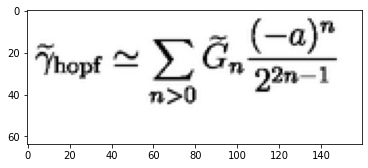

In [127]:
image_path = os.path.join(data_path, "formula_images_processed", train_formulas[0][0])
actual_formula = formulas[int(train_formulas[0][1])]
predicted_formula = inference(image_path)

# Print out the image and the generated formula
image = Image.open(image_path)
plt.imshow(np.asarray(image))
print(f"Actual: {actual_formula}")
print(f"Predicted: {predicted_formula}")

Actual: ( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \ \ ( { \cal L } _ { a } H ) _ { i j k } = 0 ,
Predicted: a _ { \cal A } ) ) = 0 ,


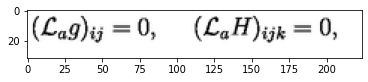

In [128]:
image_path = os.path.join(data_path, "formula_images_processed", train_formulas[1][0])
actual_formula = formulas[int(train_formulas[1][1])]
predicted_formula = inference(image_path)

# Print out the image and the generated formula
image = Image.open(image_path)
plt.imshow(np.asarray(image))
print(f"Actual: {actual_formula}")
print(f"Predicted: {predicted_formula}")